In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
rcParams['axes.unicode_minus'] = False   # 解决负号显示问题

In [149]:

# ====================
# 数据预处理与奖牌编码
# ====================
def load_and_preprocess(filepath):
    """加载数据并进行预处理"""
    df = pd.read_csv(filepath)

    # 3. 统计每个项目中不同奖牌的数量
    medal_count = df.groupby(['Team', 'Year', 'Event', 'Medal']).size().reset_index(name='Medal_Count')
    
    # 4. 判断是否为团体赛：如果某个项目中有多个运动员获得相同奖牌，则认为是团体赛
    medal_count['Is_Team_Event'] = medal_count['Medal_Count'].apply(lambda x: 1 if x > 1 else 0)
    
    # 5. 将团体赛的标记合并回运动员数据
    df = pd.merge(df, medal_count[['Team', 'Year', 'Event', 'Medal', 'Is_Team_Event']], 
                        on=['Team', 'Year', 'Event', 'Medal'], how='left')
    
    
    # 6. 对团体赛进行处理：保留第一个获奖运动员，其他运动员的奖牌数设为0
    # 按照 Team, Year, Event 和 Medal 排序，确保团体赛中的第一个运动员出现在前面
    athletes = df.sort_values(by=['Team', 'Year', 'Event', 'Medal', 'Name'])
    
    # 标记每个团体赛的第一个运动员
    athletes['Is_First_Athlete'] = athletes.groupby(['Team', 'Year', 'Event', 'Medal'])['Name'].transform('first') == athletes['Name']
    
    # 7. 计算奖牌数：对于团体赛，只有第一个运动员的奖牌数作数，其他为0
    athletes["Medal"] = athletes.apply(
        lambda x: x["Medal"] if x["Is_First_Athlete"] or x["Is_Team_Event"] == 0 else "No medal", 
        axis=1
    )
    
    # 奖牌数值映射（保留等级信息）
    medal_map = {
        'No medal': 0,
        'Bronze': 0.2,
        'Silver': 0.5,
        'Gold': 1
    }
    athletes['Medal_Value'] = athletes['Medal'].map(medal_map)
    # 删除团体赛标记
    athletes.drop(['Is_First_Athlete',"Is_Team_Event"],inplace=True, axis=1)
    # print(athletes.head())
    
    return athletes

In [216]:
# ====================
# 特征工程模块
# ====================
def calculate_features(df):
    """计算关键特征（修复Jaccard索引计算）"""
    # 按国家-项目-年份聚合
    medal_df = df.groupby(['NOC', 'Event', 'Year'])['Medal_Value'].sum().reset_index()
    
    # 改进的运动员流动性计算（3年窗口）
    athlete_sets = df.groupby(['NOC', 'Event', 'Year'])['Name'].apply(set)
    jaccard = athlete_sets.groupby(['NOC', 'Event']).apply(
        lambda x: pd.Series(
            [len(x.iloc[i] & x.iloc[i-1]) / len(x.iloc[i] | x.iloc[i-1]) 
             if i > 0 else 0 for i in range(len(x))],
            index=x.index.get_level_values('Year')
        )
    ).reset_index(name='Athlete_Jaccard')
    
    # 核心运动员保留率
    medalists = df[df['Medal_Value'] > 0].groupby(['NOC', 'Event', 'Year'])['Name'].apply(set)
    core_retention = medalists.groupby(['NOC', 'Event']).apply(
        lambda x: pd.Series(
            [len(x.iloc[i] & x.iloc[i-1]) / max(1, len(x.iloc[i-1])) 
             if i > 0 else 0 for i in range(len(x))],
            index=x.index.get_level_values('Year')
        )
    ).reset_index(name='Core_Retention')
    # 合并特征
    features = pd.merge(medal_df, jaccard, on=['NOC', 'Event', 'Year'], how='left')
    features = pd.merge(features, core_retention, on=['NOC', 'Event', 'Year'], how='left')
    
    features['Athlete_Jaccard'] = features['Athlete_Jaccard'].fillna(0)
    features['Core_Retention'] = features['Core_Retention'].fillna(0)
    
    return features

# ====================
# CUSUM计算函数
# ====================
def calculate_cusum(data_series, window_size=2, K_ratio=0.3, sensitivity=0.999):
    """改进的CUSUM算法（确保CUSUM值与阈值匹配）"""
    n = len(data_series)
    cusum = np.zeros(n)
    threshold = np.zeros(n)
    
    for t in range(1, n):
        # 动态基线（最近window_size个点）
        start_idx = max(0, t - window_size)
        baseline = data_series.iloc[start_idx:t]
        
        mu = baseline.mean()
        sigma = baseline.std() + 1e-6  # 避免除零
        
        # 计算当前差值（归一化）
        diff = (data_series.iloc[t] - mu - K_ratio*sigma) / sigma
        cusum[t] = max(0, cusum[t-1] + diff)
        
        # 动态阈值：基于归一化后的CUSUM值
        if t < window_size:
            threshold[t] = np.percentile(cusum[:t], sensitivity*100)
        else:
            threshold[t] = np.percentile(cusum[t-window_size:t], sensitivity*100)
    
    return pd.Series(cusum, index=data_series.index), pd.Series(threshold, index=data_series.index)
        
# ====================
# 可视化函数（改进版）
# ====================
def plot_coach_effect_with_threshold(features, noc, event):
    """可视化CUSUM值和动态阈值"""
    
    target_data = features[
        (features['NOC'] == noc) & 
        (features['Event'] == event)
    ].set_index('Year').sort_index()
    
    # 计算CUSUM和动态阈值
    cusum_values, threshold = calculate_cusum(target_data['Medal_Value'])
    
    # 创建画布
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 绘制奖牌趋势
    ax1.plot(target_data.index, target_data['Medal_Value'], 
             marker='o', color='#1f77b4', label='Total Medal Value')
    ax1.set_ylabel("Total Medal Value", color='#1f77b4')
    ax1.tick_params(axis='y', labelcolor='#1f77b4')
    
    # 绘制CUSUM和动态阈值
    ax2 = ax1.twinx()
    ax2.plot(target_data.index, cusum_values, 
             linestyle='--', color='#ff7f0e', label='CUSUM')
    ax2.plot(target_data.index, threshold, 
             linestyle=':', color='#2ca02c', label='Dynamic Threshhold')
    ax2.set_ylabel("CUSUM", color='#ff7f0e')
    ax2.tick_params(axis='y', labelcolor='#ff7f0e')
    
    ax1.set_title(f"{noc} {event} 'Great Coach' Effect Analysis", fontsize=14, pad=20)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
# ====================
# 检测器类
# ====================
class CoachEffectDetector:
    def detect(self, group_data):  # ✅ 只需传入分组后的数据
        """检测单个国家-项目组合的教练效应"""
        if len(group_data) < 3:
            return False
        
        # # 从分组数据中提取必要信息
        # noc = group_data["NOC"].iloc[0]  # 直接从分组数据获取NOC
        # Event = group_data["Event"].iloc[0]  # 直接从分组数据获取Event
        
        cusum, threshold = calculate_cusum(group_data['Medal_Value'])
        condition1 = (cusum.iloc[-1] >= 1.5*threshold.iloc[-1] )
        condition2 = (group_data['Core_Retention'].iloc[-1] < 0.2)
        condition3 = (group_data["Medal_Value"].iloc[-1] >0.3>group_data["Medal_Value"].iloc[-2])
        return condition1  and condition3 and condition2

In [217]:

# ====================
# 主程序
# ====================

# 数据加载与预处理
df = load_and_preprocess("2025_Problem_C_Data\\summerOly_athletes.csv")

# 特征计算
features = calculate_features(df)

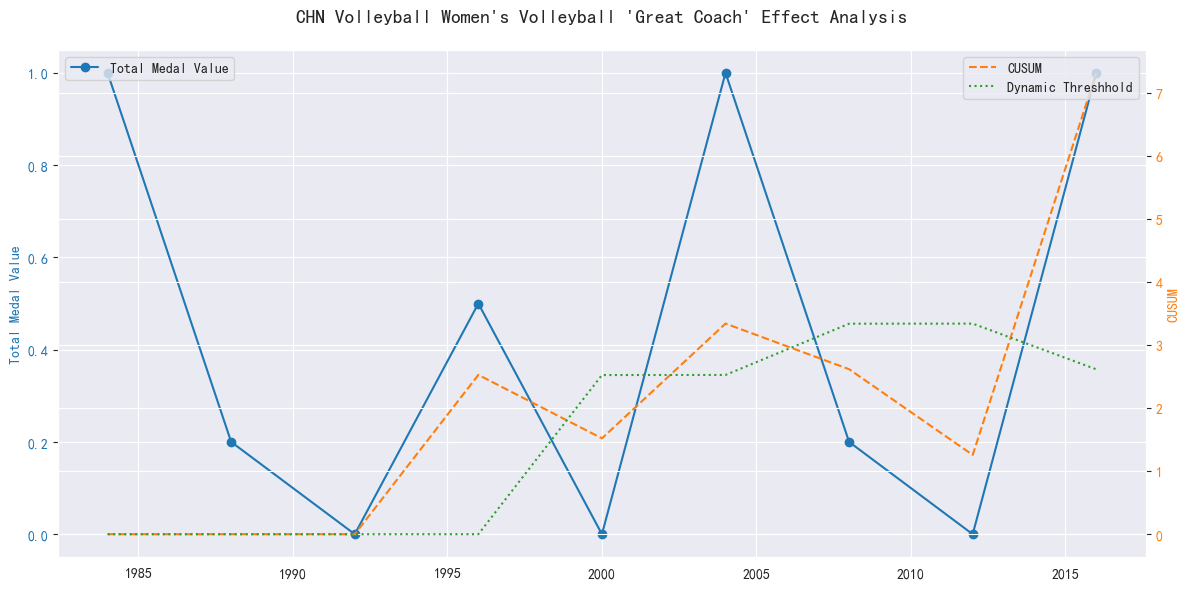

In [218]:

# 示例分析：体操
plot_coach_effect_with_threshold(features, 'CHN', 'Volleyball Women\'s Volleyball')


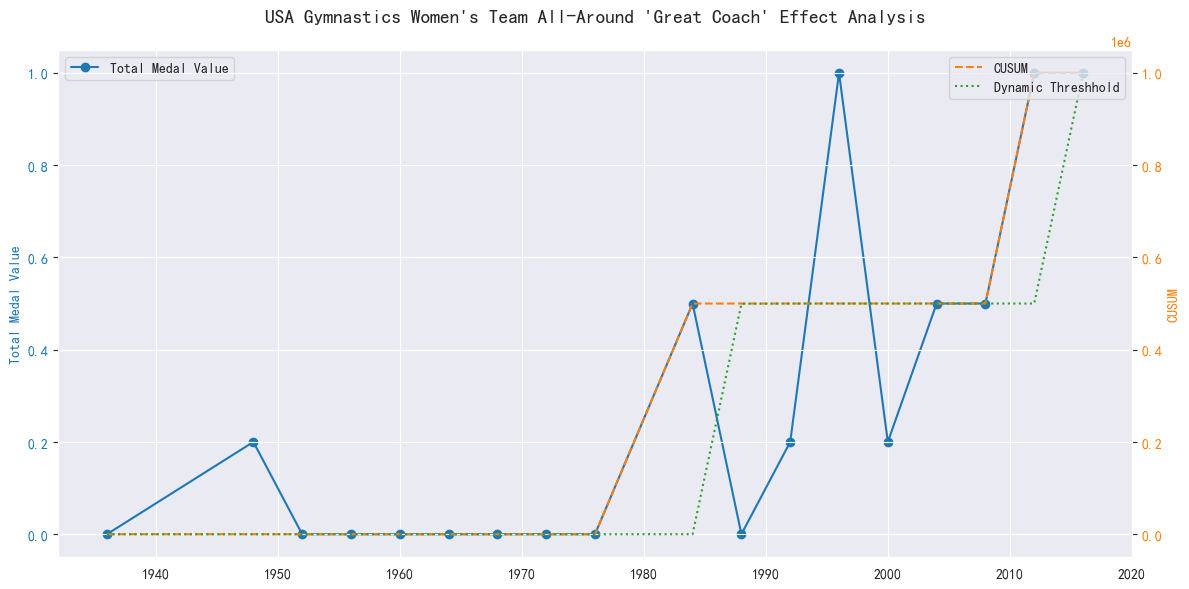

In [219]:
plot_coach_effect_with_threshold(features,"USA", "Gymnastics Women's Team All-Around")

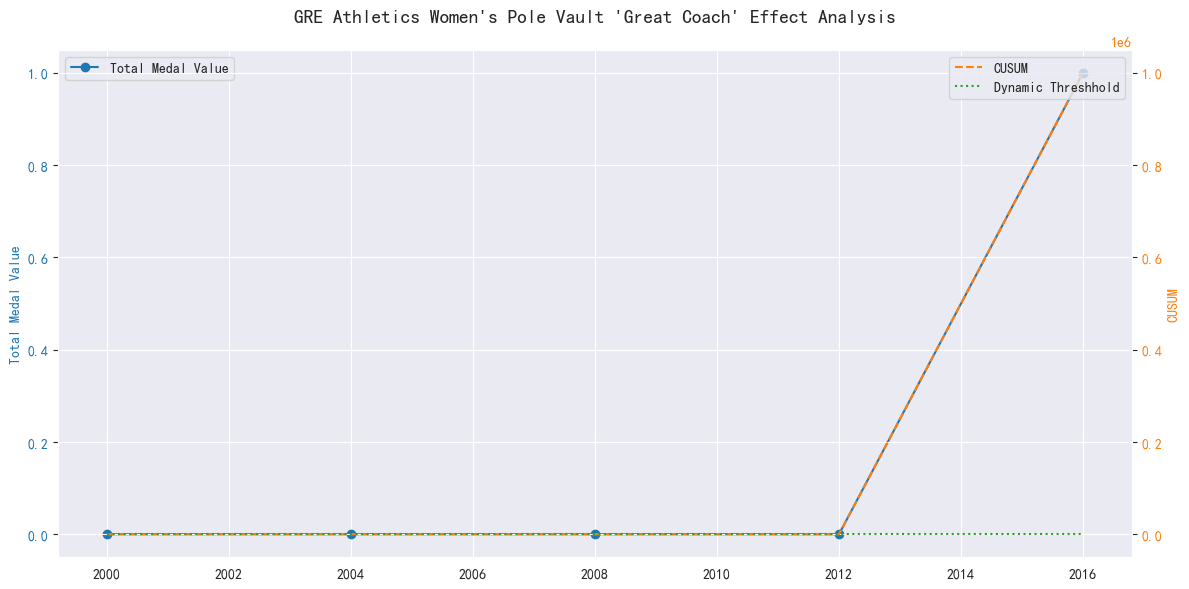

In [220]:
# 希腊女子撑杆
plot_coach_effect_with_threshold(features,"GRE", "Athletics Women\'s Pole Vault")

In [221]:

# ====================
# 修正后的检测逻辑
# ====================
print("\n=== 潜在教练效应检测 ===")
detector = CoachEffectDetector()
positive_cases = []
for (noc, event), group in features.groupby(['NOC', 'Event']):
    if detector.detect(group):  # ✅ 只需传入分组数据group
        positive_cases.append((noc, event))
print(f"检测到项目有历史记录的最后一年，可能有 {len(positive_cases)} 个潜在案例：")
for case in positive_cases:
    print(f"- Nation: {case[0]}, Event: {case[1]}")


=== 潜在教练效应检测 ===
检测到项目有历史记录的最后一年，可能有 396 个潜在案例：
- Nation: ALG, Event: Athletics Men's 800 metres
- Nation: ARG, Event: Cycling Men's Madison
- Nation: ARG, Event: Hockey Men's Hockey
- Nation: ARG, Event: Sailing Mixed Multihull
- Nation: ARM, Event: Weightlifting Men's Super-Heavyweight
- Nation: ARM, Event: Wrestling Men's Welterweight, Greco-Roman
- Nation: AUS, Event: Baseball Men's Baseball
- Nation: AUS, Event: Modern Pentathlon Women's Individual
- Nation: AUS, Event: Rowing Women's Coxless Pairs
- Nation: AUS, Event: Sailing Women's Three Person Keelboat
- Nation: AUS, Event: Shooting Women's Trap
- Nation: AUS, Event: Swimming Men's 200 metres Backstroke
- Nation: AUS, Event: Swimming Men's 400 metres Freestyle
- Nation: AUT, Event: Athletics Women's 800 metres
- Nation: AUT, Event: Sailing Men's Windsurfer
- Nation: AUT, Event: Sailing Mixed One Person Dinghy
- Nation: AZE, Event: Judo Men's Half-Heavyweight
- Nation: AZE, Event: Judo Men's Lightweight
- Nation: AZE, Event: 